## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [2]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [3]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
{'ACACAURI': 111, 'ANACOCCI': 53, 'CATALONG': 75, 'MANGINDI': 149}
4  classes found


Text(0.5, 1.0, 'Count per class')

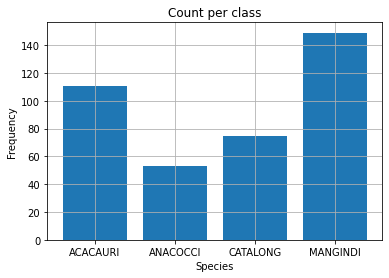

In [4]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [5]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [6]:
X = np.vstack([np.array(img.resize((28, 28))).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

Explained variation per principal component: [15.39053031  7.30257177  5.59287422  3.53779182  2.75368992  2.58201921
  1.93805454  1.88549054  1.65496814  1.42914802  1.33058438  1.23746981
  1.17390214  1.0748833   1.0016665   0.98830716  0.93795313  0.88086455
  0.8416315   0.80212054  0.74502394  0.72730984  0.71023468  0.67186723
  0.64583304  0.62605115  0.60962478  0.58286032  0.57040833  0.54662954
  0.53365162  0.52977758  0.52139473  0.49810937  0.49418387  0.48388942
  0.46661081  0.45120955  0.43696416  0.42892931  0.42577104  0.40436731
  0.39177183  0.39000578  0.38214061  0.36934612  0.36655388  0.35687356
  0.35362841  0.34840762]
69.40595095898962 % variance explained total


In [7]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [8]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  0.242237 -1.788504  ACACAURI    0.0
1 -3.114792  0.122220  ACACAURI    0.0
2  0.703856 -0.676429  ACACAURI    0.0
3  0.783652  0.762908  ACACAURI    0.0
4 -0.404320 -0.842602  ACACAURI    0.0


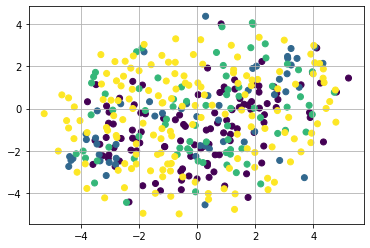

In [9]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


In [10]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [12]:
val_split = 0.3
num_epochs = 200

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

transform = T.Compose([T.Resize(512), 
                       T.CenterCrop(299), 
                       T.RandomRotation(degrees=(0, 20)),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(), 
                       T.ToTensor()])

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [13]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.005)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Device:  cuda:0


In [14]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
3  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
4  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  
0  https://treetracker-production-images.s3.eu-ce...  
1  https://treetracker-production-images.s3.eu-ce...  
2  https://treetracker-production-images.s3.eu-ce...  
3  https://treetracker-production-images.s3.eu-ce...  
4  https://treetracker-production-images.s3.eu-ce...  


In [15]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    tr_samples = 0
    n_tr_batches = 0
    for batch_x, batch_y in tr_dataloader:
        n_tr_batches += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        tr_samples += batch_y.size()[0]
    with torch.no_grad():
        n_val_batches = 0
        val_samples = 0
        running_val_loss = 0
        val_acc_sum = 0
        for val_x, val_y in val_dataloader:
            n_val_batches += 1
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            running_val_loss += val_loss.item()
            val_acc_sum += torch.sum(torch.argmax(val_output.logits, dim=1) == val_y) # wrote this way just in case there's batched validation
            val_samples += val_y.size()[0]
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
    print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
    print ("=" * 40)
print ("Finished training")

Epoch 1 finished in 35.937635 seconds
Training/Validation Loss per Batch: 1.778182/ 1.086850
Training/Validation Accuracy (percent): 33.620689 /52.573528
Epoch 2 finished in 16.342464 seconds
Training/Validation Loss per Batch: 1.136100/ 1.154737
Training/Validation Accuracy (percent): 48.275864 /50.735294
Epoch 3 finished in 16.269324 seconds
Training/Validation Loss per Batch: 1.380027/ 0.825598
Training/Validation Accuracy (percent): 48.275864 /62.500000
Epoch 4 finished in 16.401849 seconds
Training/Validation Loss per Batch: 1.316732/ 0.771618
Training/Validation Accuracy (percent): 49.137932 /62.867649


KeyboardInterrupt: 

In [39]:
# Pl@ntNet comparison

username = "shubhomb"
API_KEY = "2b10apPYIJgFw5XTChueBLJXfe"

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import logging

import http.client
http.client.HTTPConnection.debuglevel = 1

# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
requests_log = logging.getLogger("requests.packages.urllib3")
requests_log.setLevel(logging.DEBUG)
requests_log.propagate = True


api_endpoint = "https://my-api.plantnet.org/v2/identify/all?api-key=%s"%API_KEY
# path = os.path.join(savepath, tr_dataset.data.iloc[0]["class"], tr_dataset.data.imname[0])

session = requests.Session()
retry = Retry(connect=10, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)


def get_plantnet_result(path):
#     df = df.T
#     try:
#         files = [
#         ('images', (path, open(path, "rb"))),
#         ]
#     except:
#         return None
#     reqdata={'organs':['leaf']}

#     json_result = None
#     print ("Found image, continuing to HTTP stuff")
#     req = requests.Request('POST', url=api_endpoint, files=files, data=reqdata)
#     prepared = req.prepare()
#     print (req)
#     response = session.send(prepared)
#     print (response)
#     json_result = json.loads(response.text)

    return json_result

pathmaker = lambda df: os.path.join(savepath, df["class"], df["imname"])

import urllib.parse

def make_plantnet_request(url):
    '''
    Needs to be changed if you need non-leaf features
    '''
    params = {'key': API_KEY, 'images': url, 'organs': 'leaf'}
    encoded_params = urllib.parse.urlencode(params)
    print (encoded_params)
    url = "https://my-api.plantnet.org/v2/identify/all?%s"%encoded_params
    response = requests.get(url)
    print (response.status_code)
    return response
    
data['path'] = data.apply(pathmaker, axis=1)
data['plantnet_output'] = data['url'].apply(make_plantnet_request)

# species_output = data.apply(get_plantnet_result, axis=1)
# print (species_output)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): my-api.plantnet.org:443


key=2b10apPYIJgFw5XTChueBLJXfe&images=https%3A%2F%2Ftreetracker-production-images.s3.eu-central-1.amazonaws.com%2F2020.11.29.12.18.36_18.285143729299307_-73.56444373726845_860956e3-6acf-4441-b5dc-f981c93872c5_IMG_20201127_074118_842354913958461533.jpg&organs=leaf


ConnectionError: HTTPSConnectionPool(host='my-api.plantnet.org', port=443): Max retries exceeded with url: /v2/identify/all?key=2b10apPYIJgFw5XTChueBLJXfe&images=https%3A%2F%2Ftreetracker-production-images.s3.eu-central-1.amazonaws.com%2F2020.11.29.12.18.36_18.285143729299307_-73.56444373726845_860956e3-6acf-4441-b5dc-f981c93872c5_IMG_20201127_074118_842354913958461533.jpg&organs=leaf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3f6002bdd8>: Failed to establish a new connection: [Errno 110] Connection timed out',))